In [13]:
import numpy as np
import networkx as nx
import pickle as pkl
import argparse
import scipy.sparse as sp
import scipy.optimize as opt
import matplotlib.pyplot as plt
from numba import njit
import pandas as pd
from scipy.stats import linregress, binned_statistic
from skimage import measure
import skimage

In [100]:
def cluster_length(x, y):
    cloud = np.vstack([x-np.mean(x), y-np.mean(y)])
    cov_cloud = np.cov(cloud, rowvar=True, bias=True)
    eigvals, eigvecs = np.linalg.eigh(cov_cloud)
    return np.sqrt(eigvals[1])

In [101]:
def segment_no_events(data, no_event_val=-1):
    no_events_regions = [r.astype('int') for r in measure.find_contours(data, no_event_val)]
    no_events_regions_sizes = np.array([r.shape[0] for r in no_events_regions])
    sorted_regions_idx = np.argsort(no_events_regions_sizes)
    inner_region = no_events_regions[sorted_regions_idx[-2]]
    outer_region = no_events_regions[sorted_regions_idx[-1]] # the outer region is the largest
    center = inner_region.mean(axis=0)
    return inner_region, outer_region, center

In [102]:
field = 0.14
basename = "data/file_field"
filename = basename + "%1.2f_events.pkl" % field
with open(filename, 'rb') as file:
    xs, ys = pkl.load(file)
data = np.loadtxt(basename + "%1.2f.csv" % field, delimiter=",").astype('int')
inner_region, outer_region, center = segment_no_events(data,  no_event_val=-1)

In [103]:
def kolton_aggregate(x_data, y_data, n_frames, d_max = 2):
    t_arr = np.array(list(x_data.keys()))
    clustered = {t : False for t in t_arr}
    clusters = []
    for idx, t in enumerate(t_arr):
        if(clustered[t]):
            continue
        clustered[t] = True
        cluster = [t]
        x = x_data[t]
        y = y_data[t]
        for s in t_arr[idx+1:idx+n_frames+1]:
            if(clustered[s]):
                continue
            if((s-t) <= n_frames):
                x_p = x_data[s]
                y_p = y_data[s]
                min_d = np.min(np.abs(x[:,None]-x_p[None,:])+np.abs(y[:,None]-y_p[None,:]))
                if(min_d <= d_max):
                    clustered[s] = True
                    cluster.append(s)
        clusters.append(cluster)
    return clusters

In [104]:
raw = np.array([len(x) for x in xs.values()])

In [110]:
kolton_clusters = kolton_aggregate(xs, ys, 3)

In [111]:
kolton_sizes = []
kolton_lengths = []
for clus in kolton_clusters:
    kolton_sizes.append(np.sum([len(xs[c]) for c in clus]))
    kolton_lengths.append( cluster_length(np.concatenate([ xs[c]  for c in clus]), np.concatenate([ ys[c]  for c in clus])))
kolton_sizes = np.array(kolton_sizes)
kolton_lengths = np.array(kolton_lengths)

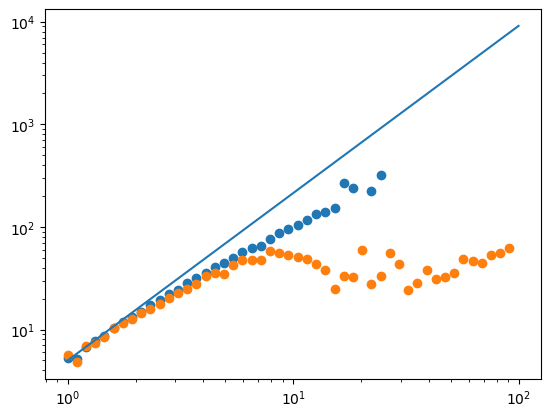

In [114]:
y_stat, x_bins, _ = binned_statistic(kolton_lengths, kolton_sizes, statistic='mean', bins=np.logspace(0, 2))
plt.scatter(x_bins[:-1], y_stat)
y_stat, x_bins, _ = binned_statistic(df_lengths[22], df_sizes[22], statistic='mean', bins=np.logspace(0, 2))
plt.scatter(x_bins[:-1], y_stat)
plt.plot(x_bins, 5*x_bins**1.63)
plt.xscale('log')
plt.yscale('log')

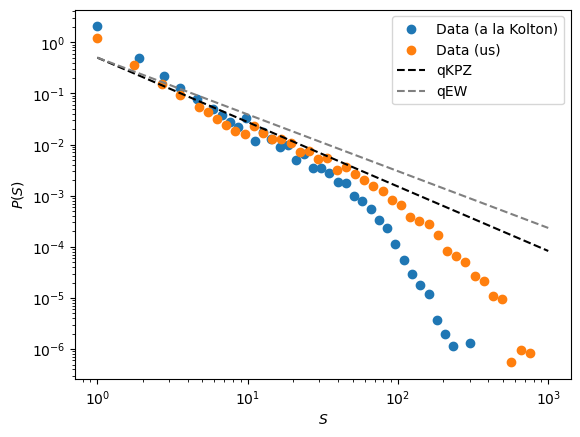

In [ ]:
hist, edges = np.histogram(kolton_sizes, bins=np.logspace(0,2.7), density=True)
plt.scatter(edges[:-1], hist, label="Data (a la Kolton)")
hist, edges = np.histogram(df_sizes[22], bins=np.logspace(0,3), density=True)
plt.scatter(edges[:-1], hist, label="Data (us)")
#plt.plot(edges, 3*edges**(-1.7), label="$P(S) \sim S^{-2}$", ls='dashed', color='black')
plt.plot(edges, 0.5*edges**(-1.26), label="qKPZ", ls='dashed', color='black')
plt.plot(edges, 0.5*edges**(-1.11), label="qEW", ls='dashed', color='grey')
plt.legend()
plt.xlabel("$S$")
plt.ylabel("$P(S)$")
plt.xscale('log')
plt.yscale('log')

In [108]:
dts = [10,12,14,16,18,20,22]
basename = "data/file_field"
ds = 3

In [109]:
dfs = {}
df_sizes = {}
df_lengths = {}
for dt in dts:
    print(dt)

    sparse_net_filename = basename + "%1.2f_net_dt=%i.npz" % (field, dt)
    filename = basename + "%1.2f_events.pkl" % field
    with open(filename, 'rb') as file:
        xs, ys = pkl.load(file)

    sparse_net  = sp.load_npz(sparse_net_filename)
    net = nx.Graph(sparse_net)
    # filter out all edges
    long_edges = list(filter(lambda e: e[2] > ds, (e for e in net.edges.data('weight'))))
    le_ids = list(e[:2] for e in long_edges)
    # remove filtered edges from graph
    net.remove_edges_from(le_ids)
    clusters = []
    comps = nx.connected_components(net)
    for comp in comps:
        clusters.append(np.sort(list(comp)))
    print("Number of clusters:", len(clusters))
    cl_sizes = []
    cl_growth = []
    cl_start_times = []
    cl_end_times = []
    cl_lengths = []
    for cluster in clusters:
        x_c = []
        y_c = []
        linear_stats = []
        total_pixels = 0
        first_cluster_time = None
        end_cluster_time = -1
        for c in cluster:
            if(c in xs):
                end_cluster_time = c
                if(first_cluster_time is None):
                    first_cluster_time = c
                total_pixels += len(xs[c])
                x_c.append(xs[c])
                y_c.append(ys[c])
                linear_stats.append((c, cluster_length(np.concatenate(x_c), np.concatenate(y_c)), total_pixels, first_cluster_time, end_cluster_time))
        if(len(x_c)==0):
            continue
        linear_stats = np.array(linear_stats)
        linear_stats[:, 0] -= linear_stats[0,0]
        linear_stats[:, -1] = end_cluster_time
        cl_growth.append(linear_stats)
        x_c = np.concatenate(x_c)
        y_c = np.concatenate(y_c)
        cl_sizes.append(len(x_c))
        cl_start_times.append(first_cluster_time)
        cl_end_times.append(end_cluster_time)
        cl_lengths.append(cluster_length(x_c, y_c))
    cl_sizes = np.array(cl_sizes)
    cl_lengths = np.array(cl_lengths)
    cl_start_times = np.array(cl_start_times)
    cl_end_times = np.array(cl_end_times)
    cl_growth = np.concatenate(cl_growth, axis=0)
    df_growth = pd.DataFrame()
    df_growth['timeIdx'] = cl_growth[:,0]
    df_growth['linear'] = cl_growth[:,1]
    df_growth['area'] = cl_growth[:,2]
    df_growth['area_sq'] = cl_growth[:,2]**2
    df_growth['area_cube'] = cl_growth[:,2]**3
    df_growth['cStart'] = cl_growth[:,3]
    df_growth['cEnd'] = cl_growth[:,4]
    #df_growth = df_growth[df_growth['cEnd']>30000]
    groups_mean = df_growth.groupby('timeIdx').mean()
    dfs[dt] = df_growth
    df_sizes[dt] = cl_sizes
    df_lengths[dt] = cl_lengths
    #plt.hist(cl_sizes[cl_end_times>30000], bins=np.logspace(0,3,100), density=True)
    #plt.plot(np.logspace(0,3), 0.5*np.logspace(0,3)**(-1.26))
    #plt.yscale('log')
    #plt.xscale('log')
    #plt.show()

10
Number of clusters: 39151
12
Number of clusters: 36355
14
Number of clusters: 33392
16
Number of clusters: 30243
18
Number of clusters: 27006
20
Number of clusters: 24046
22
Number of clusters: 21342


In [81]:
linregress(np.log(1+groups_mean.index),  (groups_mean.area_cube/groups_mean.area_sq)**(-1/1.25))

LinregressResult(slope=-0.005734380678699992, intercept=0.03818469001422425, rvalue=-0.9574240845145737, pvalue=1.8135309509233697e-124, stderr=0.00011476083643528902, intercept_stderr=0.0005238310757159197)

In [82]:
linregress(np.log(1+groups_mean.index),  (groups_mean.area_cube/groups_mean.area_sq)**(-1/2.82))


LinregressResult(slope=-0.0250750301118265, intercept=0.252832548640057, rvalue=-0.951817216820478, pvalue=1.6510879455083816e-118, stderr=0.0005362168930708926, intercept_stderr=0.0024475864819333178)

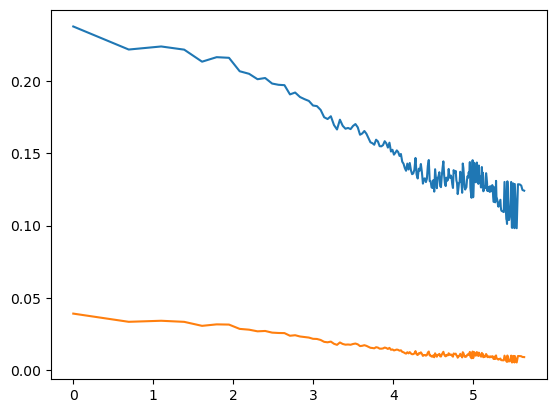

In [88]:
plt.plot(np.log(1+groups_mean.index),  (groups_mean.area_cube/groups_mean.area_sq)**(-1/2.82))
plt.plot(np.log(1+groups_mean.index),  (groups_mean.area_cube/groups_mean.area_sq)**(-1/1.25))